# Análise da hipótese tempoxpreço

Nesta notebook é feita uma análise para verificar se os preços dos produtos do dataset têm alguma dependência temporal

Caso exista dependência temporal modelos baseados em séries temporais poderão ser úteis para a precificação dos produtos. Caso não seja verificada nenhuma dependência dos dados em relação ao tempo esta informação, neste caso, não será útil para precificar os produtos cadastrados no dataset fornecido.

## Configuração do Ambiente de Trabalho

Importação das bibliotecas necessárias.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Carregamento dos dados. Aqui é utilizado o dataset contendo todos os registros fornecidos.

In [3]:
arquivo_dados = '../data/processed/train_data_prep02.csv'
dados = pd.read_csv(arquivo_dados)

O próximo passo a coluna `date`  é convertida para o formato `datetime` e definida como index do dataset. Esta conversão simplifica a manipulação de dados temporais.

In [4]:
dados['date'] = pd.to_datetime(dados['date'], dayfirst=True)
dados.set_index('date', inplace=True)

Avaliação do preço em função do tempo para as categorias principais.

Maioria é de names únicos.

In [31]:
categorias = sorted(dados.category_1.unique())

## Análise da série diária

Em virtude das caracaterísticas dos dados a análise será feita agrupando os registros por categoria principal. 

Nes primeira análise foram plotadas as séries de preços médios diários por categoria principal. Em conjunto também é exibida a média móvel de 7 dias. O objetivo é visualizar se existe algum padrão diário ou semanal (média móvel) nos dados que possa indicar alguma dependência dos preços dos produtos em função do tempo.

In [63]:
def plot_timeseries(dados, freq, window=None, label_serie='', ylabel='', xlabel='', ylim=[0, 100], legend=False):
    fig, axes = plt.subplots(3, 4, dpi=75, figsize=(22, 11))
    c, l = 0, 0
    for i, categoria in enumerate(categorias):
        l1 = dados.query(f'category_1 == "{categoria}"')\
            .resample(freq)\
            .price.mean()\
            .plot(ax=axes[l, c], label=label_serie)
        if window:
            l2 = dados.query(f'category_1 == "{categoria}"').resample(freq)\
                .price.mean()\
                .rolling(window=window).mean()\
                .plot(ax=axes[l, c], label='Média móvel')
        
        axes[l, c].set_title(categoria)
        axes[l, c].set_ylim(ylim)
        axes[l, c].set_ylabel(ylabel)
        axes[l, c].set_xlabel(xlabel)
        
        if legend and l == 0 and c == 0:
            axes[l, c].legend()

        l += 1
        if l >= 3:
            l = 0
            c += 1

    axes[-1, -1].axis('off')
    plt.show()
    

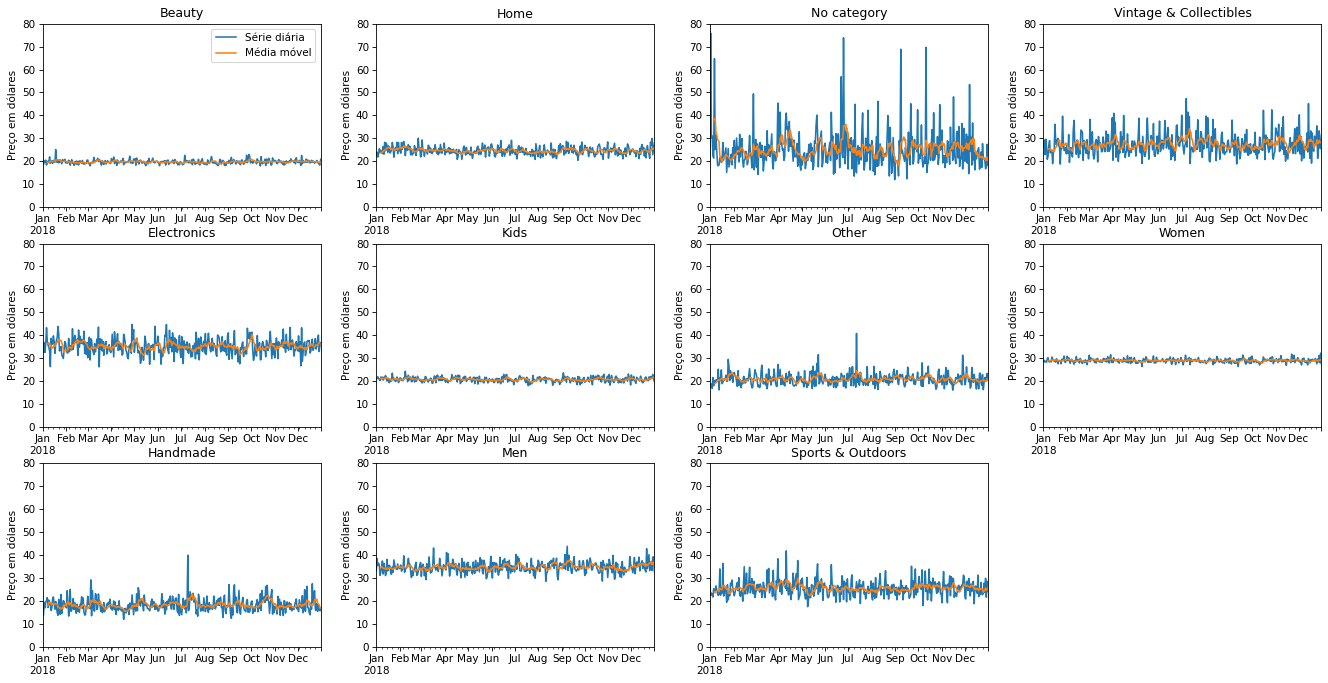

In [64]:
plot_timeseries(
    dados,
    freq = 'D',
    window = 7,
    label_serie = 'Série diária',
    ylabel = 'Preço em dólares',
    xlabel = '',
    ylim=[0, 80],
    legend = True
)

Os gráficos acima mostram que existe grande ruído nas séries diárias, não se observando um padrão de sazonalidade e/ou tendência na série. Quanto a média móvel de sete dias também não se observa claramente um padrão. Importante observar que para as categorias: `Beauty`, `Kids` e `Women` quase não se observam variações nos preços ao longo do tempo. A categoria `No category` se mostra como a mais ruídos e com os picos de preços mais elevados entre todas as categorias.

Nos gráficos é exibida a variação dos preços por dia do mês.

In [60]:
def plot_boxplots(dados, freq, x='', y='', ylabel='', xlabel=''):
    fig, axes = plt.subplots(3, 4, dpi=75, figsize=(24, 11), sharey=True, sharex=True)
    c, l = 0, 0

    for i, categoria in enumerate(categorias):
        dados_plot = dados.query(f'category_1 == "{categoria}"')
        
        if freq == 'dia':
            dados_plot = dados_plot.assign(dia=dados_plot.index.day)
        else:
            dados_plot = dados_plot.assign(mes=dados_plot.index.month)
            
        l1 = sns.boxplot(data=dados_plot, x=x, y=y, showfliers=False, ax=axes[l, c], color='c')
        axes[l, c].set_title(categoria)
        
        if c == 0:
            axes[l, c].set_ylabel(ylabel)
        else:
            axes[l, c].set_ylabel('')
            
        if (l == 2) or (l == 1 and c == 2):
            axes[l, c].set_xlabel(xlabel)
        else:
            axes[l, c].set_xlabel('')

        l += 1
        if l >= 3:
            l = 0
            c += 1

    axes[-1, -1].axis('off')
    plt.tight_layout()
    plt.show()

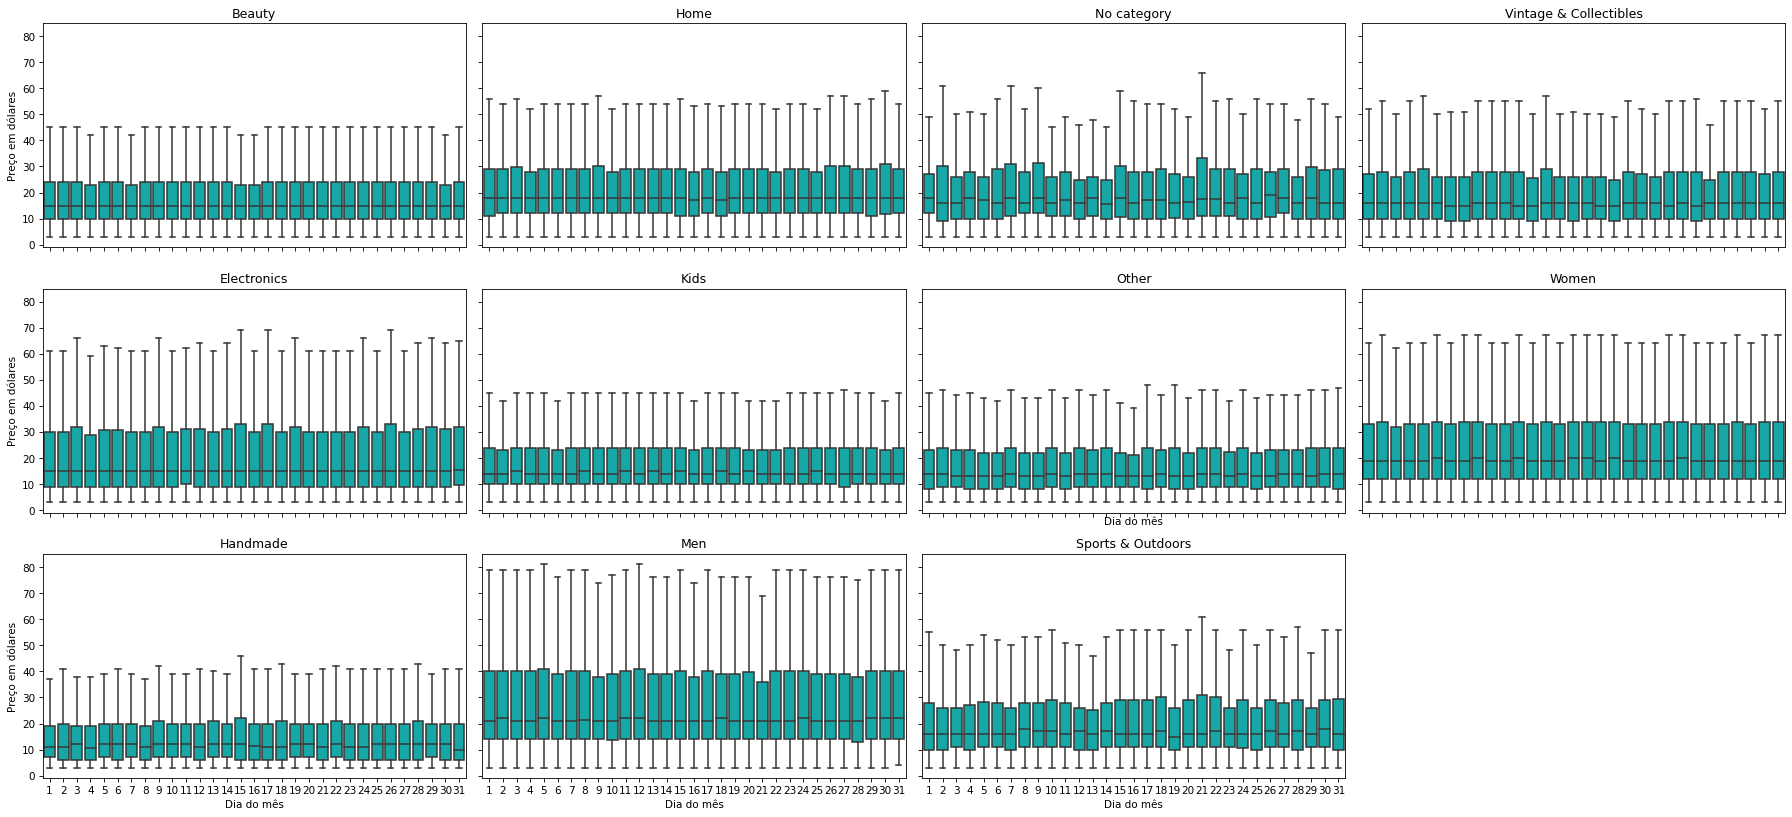

In [71]:
plot_boxplots(
    dados,
    freq = 'dia',
    x = 'dia',
    y = 'price',
    ylabel = 'Preço em dólares',
    xlabel = 'Dia do mês'
)

Novamente não se observa nenhum sinal de dependência temporal dos dados. Em todas as categorias as caixas dos boxplots têm praticamente a mesma amplitude e mesma mediana. Os máximaos e mínimos também não apresentam grandes variações pelo dia do mês.

Optou-se em não destacar os outilers para ter-se uma visão mais enxuta e concentrado na região onde a maioria dos dados está presente. Porém, há sim outilers no dataset em todas as categorias eles apenas não foram exibidos.

## Análise das séries mensais

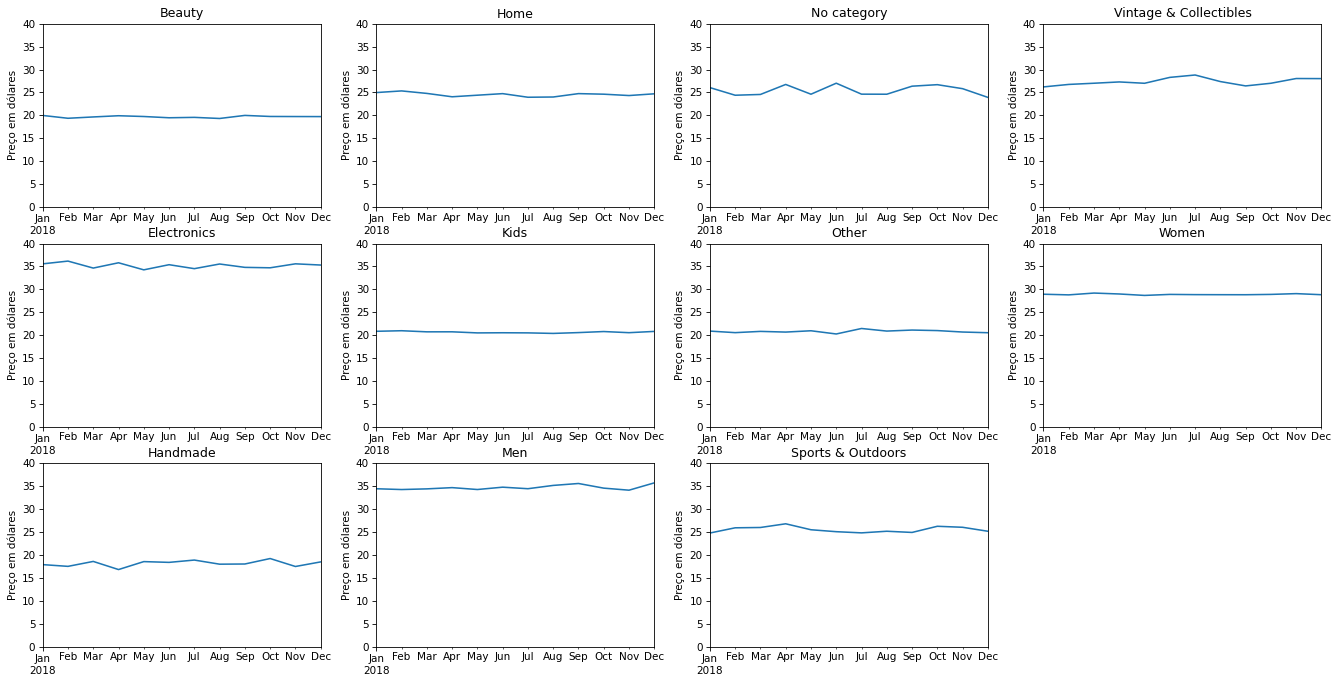

In [68]:
plot_timeseries(
    dados,
    freq = 'M',
    label_serie = None,
    ylabel = 'Preço em dólares',
    xlabel = '',
    ylim=[0, 40],
)

Considerando-se a média mensal, mostrada nos gráficos acima, o sinal é ainda mais claro da falta de dependência temporal dos dados. Em todas as médias mensais são quase uma constante ao longo do tempo. Destacam-se as categorias `Electronics` e `Men` por terem médias de preço superior as demais categorias.

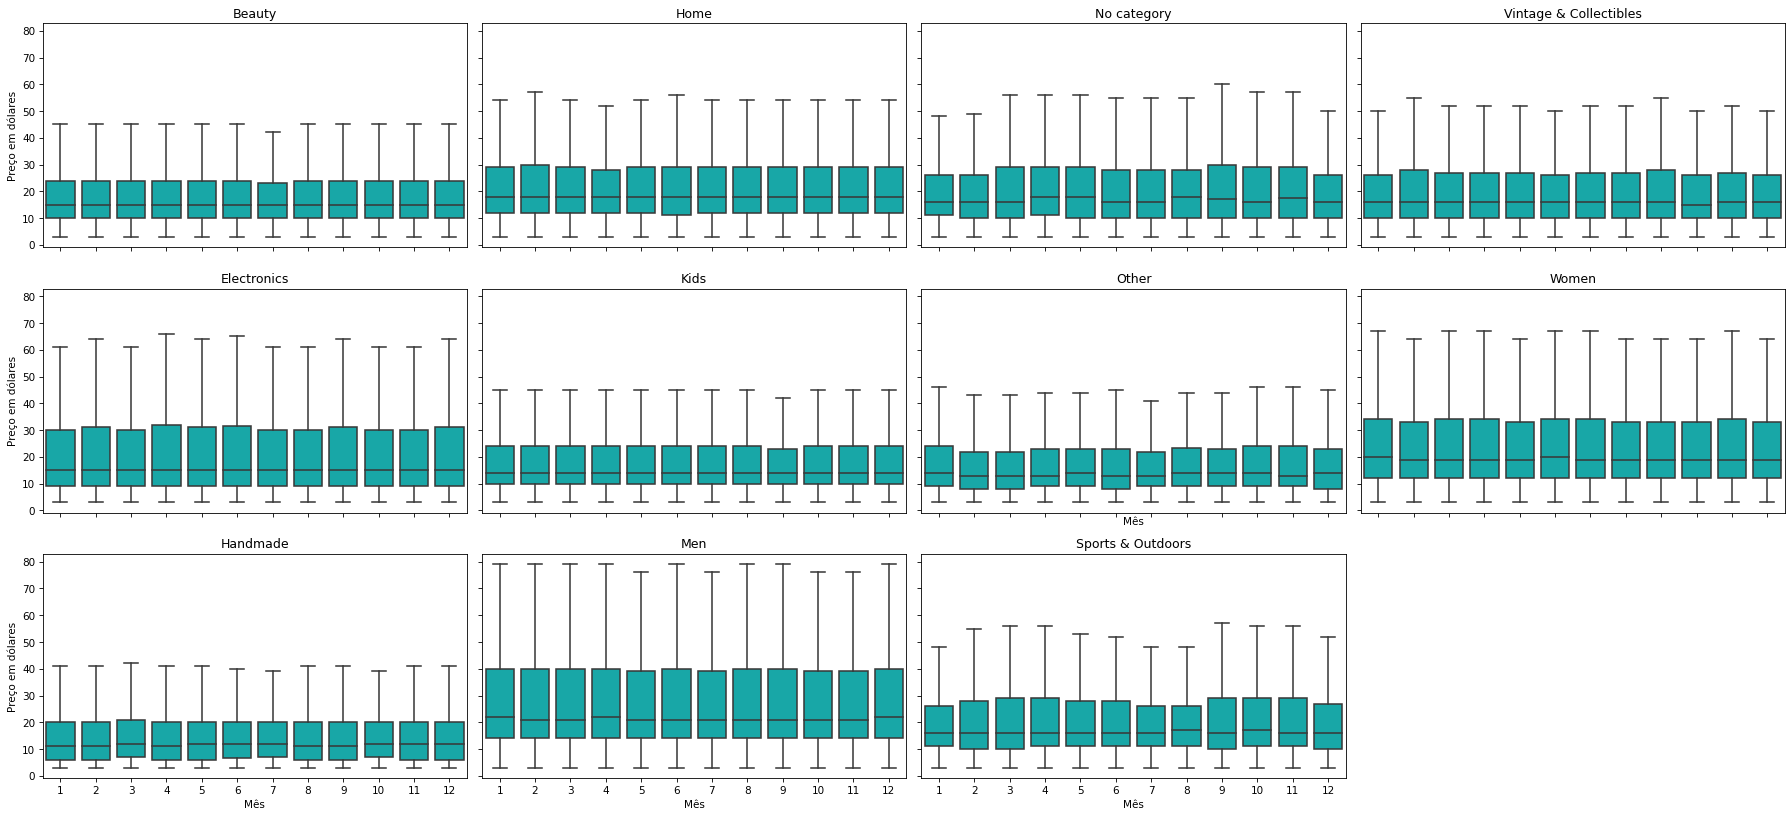

In [70]:
plot_boxplots(
    dados,
    freq = 'mes',
    x = 'mes',
    y = 'price',
    ylabel = 'Preço em dólares',
    xlabel = 'Mês'
)

Novamente os boxplotos mostram que a distribuição dos preços ao longo dos meses é praticamente identica. Existem apenas diferenças entre categorias.

## Teste de autocorrelação

O teste de autocorrelação é empregado para verificar se há dependência temporal significativa na série. Caso exista o teste irá mostrar em quais passos de tempos a correlação significativa. Este é um importante teste para a modelagem de modelos autoregressivos de séries temporais.

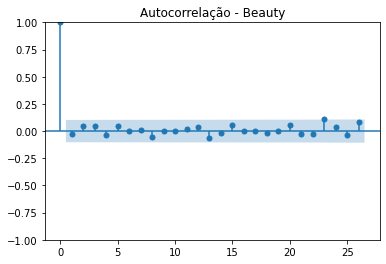

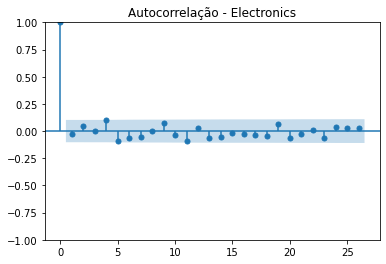

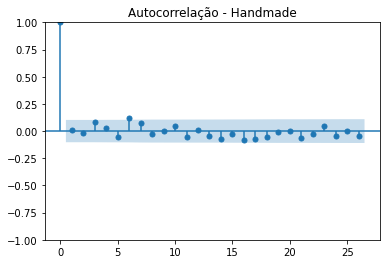

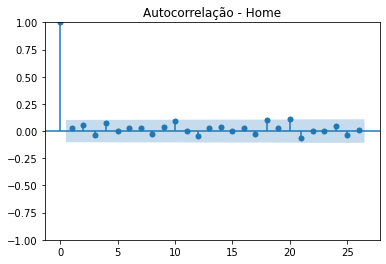

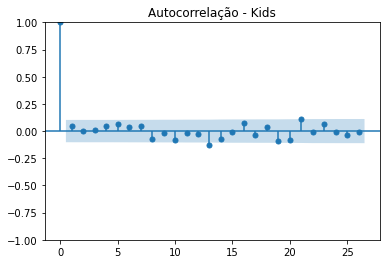

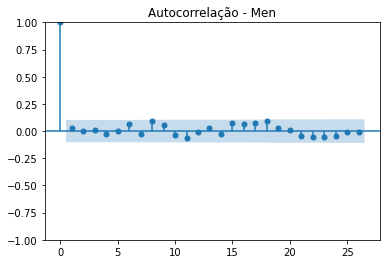

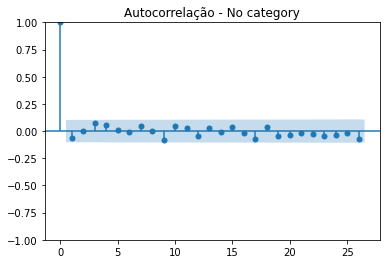

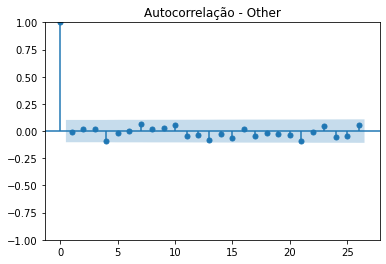

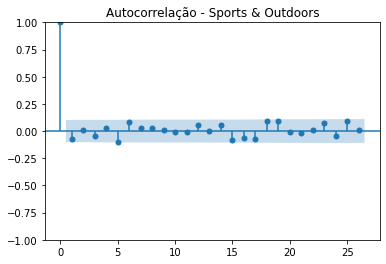

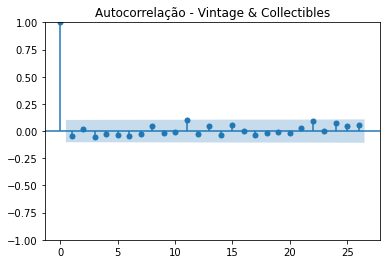

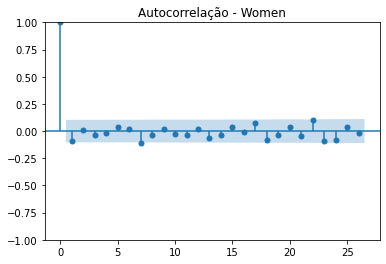

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

for categoria in categorias:
    dados_plot = dados.query(f'category_1 == "{categoria}"')\
        .resample('D')\
        .price.mean()
    
    plot_acf(dados_plot)
    plt.title(f'Autocorrelação - {categoria}')
    plt.show()

Nos gráficos de autocorrelação:

O eixo x são os lags (defasagem que é aplicada na série para calcular a correlção);<br>
os lollipops marcam o valor de correlação calculado entre a seŕie original e ela mesma defasada no lag correspondente;<br>
a área sombreado o intervalo de confiança de 95%.

Assim, para que exista autocorrelação significativa é necessário que os valores encontrados estejam foram da área sombreada. O primeiro valor do gráfico (1) representa a correlação da série com ela mesma sem defasagem e por isto seu valor é igual a 1 sempre. Nos demais casos, em nenhuma das categorias, foram encontrados lags com valor de autocorrelação significativos. Assim, pode-se afirmar que não há dependência temporal nos preços.

## Conclusão

A análise realizada mostra que não existe dependência temporal dos preços para este dataset. Ou seja, a hipótese de inicial de que os preços são influenciados pelo tempo está descartada.

O motivo para estes resultados está no fato das datas dos anúncios terem sido geradas de forma puramente randômica. Em um dataset real poderia sim haver uma dependência temporal do preços principalmente para os produtos de estação.